In [1]:
%matplotlib inline

# 破解驗證碼

![md_images](../Images/Imnotrobot.jpg?raw=true)

![md_images](../Images/captcha.jpg?raw=true)

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
import pickle
import PIL
from PIL import Image
from PIL.ImageDraw import Draw

import cntk as C
from cntk.ops import *
from cntk.layers import *
from cntk.losses import *
from cntk.metrics import *
from cntk.debugging import *
from cntk.logging import *
from cntk.learners import *
from cntk.train import *
from cntk.device import *

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [3]:
C.__version__

'2.6'

In [4]:
train_data=None
test_data=None

with open('../Data/mnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('../Data/mnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)
    
def parse_mnist(data):
    features=[]
    labels=[]
    for row in data:
        labels.append(np.eye(10)[row[-1]].astype(np.float32))
        features.append(row[:-1].astype(np.float32))#正規化
    return np.asarray(features),np.asarray(labels)



features,labels=parse_mnist(train_data)
print(features[:3])
print(features.shape)
print(labels.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 784)
(60000, 10)


In [5]:
#可行的字體大小，我們將字體控制在28~34級字之間
font_sizes=np.arange(28,34,2)
print(font_sizes)

#產生打亂的索引表
idxs=np.arange(0,features.shape[0],1)
np.random.shuffle(idxs)


#產生隨機顏色的函數
def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (blue, green, red)
    return (blue, green, red, opacity)


[28 30 32]


[3, 3, 1]


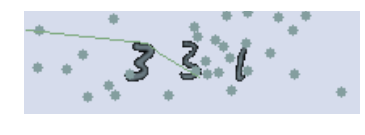

In [6]:
def get_mnist_bbox(img):
    if img[0,0]==255:
        img=255-img 
    img_y=np.greater(np.mean(img,1),0).astype(np.float32)
    img_x=np.greater(np.mean(img,0),0).astype(np.float32)
    min_y,max_y=np.argmax(img_y)-1,len(img_y)-np.argmax(np.flip(img_y.copy(),0))
    min_x,max_x=np.argmax(img_x)-1,len(img_x)-np.argmax(np.flip(img_x.copy(),0))
    return (min_x+max_x)/2.0,(min_y+max_y)/2.0,max_x-min_x+1,max_y-min_y+1

#生成干擾用的隨機線條
def create_noise_curve(image, color):
    h,w = image.shape[:2]
    for i in range(random.choice([1,2,3])):
        try:
            x0=random.randint(0, 20)
            x1 = random.randint(x0, w -3* int(w / 5))
            x2 = random.randint(x1, w -2* int(w / 5))
            x3= random.randint(x2, 208)
            y0= random.randint(int(h /10),int(h / 5))
            y1 = random.randint(y0, h -3*int(h / 5))
            y2 = random.randint(y1, h-2* int(h / 5))
            y3=random.randint(y2, h -int(h / 5))
            points =np.array([[x0, y0], [x1, y1], [x2, y2], [x3, y3]])

            image=cv2.polylines(image,np.int32([points]),False,color =color, thickness=1)
        except Exception as e:
            print(e)
    return image

#生成干擾用的隨機噪點
def create_noise_dots(image, color, width=3, number=30):
    w, h = image.shape[:2]
    while number>0:
        x1 = random.randint(0, 208)
        y1 = random.randint(0, 64)
        cv2.circle(image, (x1, y1),width,color, -1)
        number -= 1
    return image

#隨機生成出隨機數字，數字位置的Bounding Box，以及分別是甚麼數字的標籤集合
def get_minist_chaptcha_raw():
    #隨機設定字數
    words_cnt=random.choice(range(3,7))
    #隨機選擇字體大小
    font_size=random.choice(font_sizes)
    #如果字數太多不巧遇上字體過大，則覆寫為字數等於4
    if font_size*words_cnt>208:
        words_cnt=4
        if font_size*4>208:
            words_cnt=3
    
    #隨機選擇索引位置以及產出對應標籤與圖片
    idx_list=[random.choice(idxs) for d in range(words_cnt)]
    label_list=[np.argmax(labels[d]) for d in idx_list]  
    img_list=[cv2.resize(np.reshape(features[d],(28,28,1)),(font_size,font_size)) for d in idx_list]  
    bboxs_list=[get_mnist_bbox(im) for im in img_list]
    return img_list,bboxs_list,label_list


#根據get_minist_chaptcha_raw函數的產出，組合生成出驗證碼圖片。
#輸出驗證碼圖片尺寸為寬為208 高為64，為何使用208那麼怪的數字主要是後續要透過4次下採樣變成13個特徵圖網格
def get_minist_chaptcha():
    img_list,bboxs_list,label_list= get_minist_chaptcha_raw()
    new_bboxs_list=[]
    #隨機生成顏色
    background = random_color(200, 255)
    color = random_color(40,180)
    image = np.ones((64,208,3))
    image=image*np.reshape(background,(1,1,3))
    pos_x=(208-img_list[0].shape[0]*len(img_list))//2
    pos_y=(64-img_list[0].shape[1])//2
    for i in range(len(bboxs_list)):
        #將灰階轉換為三原色
        imBGR=cv2.cvtColor(img_list[i],cv2.COLOR_GRAY2BGR).astype(np.float32)
        imBGR=imBGR/255.0
        imBGR[imBGR<=0.1]=0
        imBGR=imBGR*np.reshape(color,(1,1,3))
        imBGR[np.where((imBGR==[0,0,0]).all(axis=2))] = background
        
        #接受一個隨機左右偏移量
        pos_x=pos_x+random.choice(np.arange(-3,1).tolist())
       
        
        #取出bbox定義
        (xc,yc,w,h)=bboxs_list[i]
     
        image[pos_y:pos_y+imBGR.shape[0],pos_x:pos_x+imBGR.shape[1],:]=imBGR[:,:,:]
        #塞入新bbox
        new_bboxs_list.append((xc+pos_x,yc+pos_y,w,h))
        pos_x=pos_x+imBGR.shape[1]
    image=create_noise_dots(image,random_color(120,240))
    image=create_noise_curve(image,random_color(120,240,random.randint(180, 255)))
    return image.astype(np.float32),img_list,new_bboxs_list,label_list

img_captcha,img_list,bboxs_list,label_list= get_minist_chaptcha()
img_captcha=cv2.cvtColor(img_captcha,cv2.COLOR_BGR2RGB)
img_captcha=Image.fromarray(img_captcha.astype(np.uint8))

#我們隨機生成一張驗證碼，並且將它顯示出來
plt.axis('off')
plt.imshow(img_captcha)
print(label_list)

(64, 208, 3)
float32


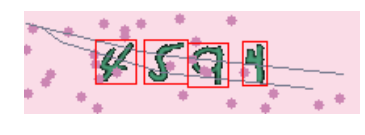

In [7]:
img_captcha,img_list,bboxs_list,label_list= get_minist_chaptcha()
print(img_captcha.shape)
print(img_captcha.dtype)
for bbox in bboxs_list:
    color =(0,0,255)
    (xc,yc,w,h)=bbox
    cv2.rectangle(img_captcha, (int(xc-0.5-0.5*w), int(yc-0.5-0.5*h)), (int(xc+0.5+0.5*w), int(yc+0.5+0.5*h)), color, 1)

img_captcha=cv2.cvtColor(img_captcha,cv2.COLOR_BGR2RGB)
img_captcha=Image.fromarray(img_captcha.astype(np.uint8))
plt.axis('off')
plt.imshow(img_captcha)   

In [9]:

#請注意，原來的tiny yolo v2的輸入圖片為416*416，透過5次下採樣(請注意最後一次maxpolling strides=1，並不是下採樣)產生了大小為13*13的特徵圖

def tiny_yolo(input):
    x=Convolution((3,3), 16, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C1')(input)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP1")(x)
    x=Convolution((3,3), 32, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C2')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP2")(x)
    x=Convolution((3,3), 64, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C3')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP3")(x)
    x=Convolution((3,3), 128, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C4')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP4")(x)
    x=Convolution((3,3), 256, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C5')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP5")(x)
    x=Convolution((3,3), 512, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C6')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(1,1), name="MP6")(x)
    x=Convolution((3,3), 1024, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C7')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=Convolution((3,3), 1024, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C8')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=Convolution((1,1), 125, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C9')(x)
    return x

#為了將輸入圖片尺寸縮小方便訓練，以及簡化模型我們將輸入圖片尺寸改為208*208，並且拿掉一組下採樣
# 最後一層特徵圖15=1種anchor*(4個bounding box迴歸參數+1個objectness+10數字類別score)
def simplify_tiny_yolo(input):
    x=Convolution((3,3), 16, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C1')(input)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP1")(x)
    x=Convolution((3,3), 32, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C2')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP2")(x)
    x=Convolution((3,3), 64, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C3')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP3")(x)
    x=Convolution((3,3), 128, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C4')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=MaxPooling(filter_shape=(2,2),strides=(2,2), name="MP4")(x)
    x=Convolution((3,3), 256, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C5')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=Convolution((3,3), 512, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C7')(x)
    x=BatchNormalization(map_rank=1)(x)
    x=Convolution((3,3), 512, activation=leaky_relu, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='C8')(x)
    x=BatchNormalization(map_rank=1)(x)
    
    bbox_center=Convolution((1,1),2, activation=sigmoid, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='bbox_center')(x)
    bbox_scale=Convolution((1,1),2, activation=None, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='bbox_scale')(x)
    bbox_objectness=Convolution((1,1),1, activation=sigmoid, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='bbox_objectness')(x)
    bbox_class=Convolution((1,1),10, activation=softmax, init=C.he_uniform(0.002), pad=True, strides=1,bias=True,name='bbox_class')(x)
    x=splice(bbox_center,bbox_scale,bbox_objectness,bbox_class,axis=0)
    return x



![md_images](../Images/bbox_regression.jpg?raw=true)

(3, 208, 208)
(15, 13, 13)
(13, 13)


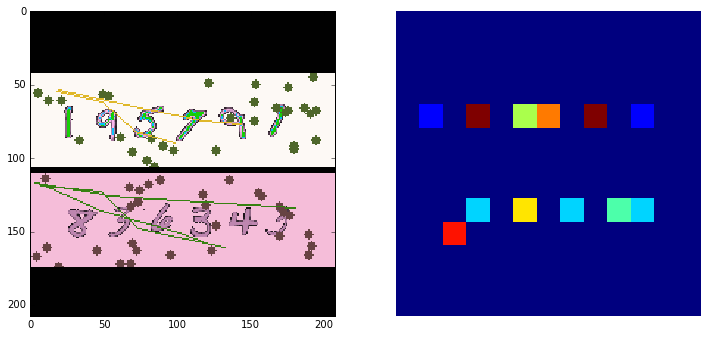

In [10]:
def get_next_minibatch(minibatch_size=1):
    features=[]
    lables=[]
    while len(features)<minibatch_size:
        h_shift=random.choice(range(60))
        h_shift2=h_shift+64+random.choice(range(10))
        img_captcha,img_list,bboxs_list,label_list= get_minist_chaptcha()
        img_captcha2,img_list2,bboxs_list2,label_list2= get_minist_chaptcha()
        
        feature=np.zeros((3,208,208),dtype=np.float32) #輸入向量基礎為全零向量
        
        #數據增強手法，將輸入向量背景變為隨機常態分佈的亂數噪音
        if random.randint(0, 10)%3==0:
            feature=np.random.standard_normal((3,208,208))*127.5+127.5
  
        img_captcha=np.transpose(img_captcha,[2,0,1])
        img_captcha2=np.transpose(img_captcha2,[2,0,1])
        
        feature[:,h_shift:h_shift+img_captcha.shape[1],:]=img_captcha
        feature[:,h_shift2:h_shift2+img_captcha2.shape[1],:]=img_captcha2
        features.append((feature-127.5)/127.5) #將輸入向量標準化為-1~1之間
        
        bboxs_list=[(box[0],box[1]+h_shift,box[2],box[3]) for box in bboxs_list]
        bboxs_list2=[(box[0],box[1]+h_shift2,box[2],box[3]) for box in bboxs_list2]
        
        bboxs_list.extend(bboxs_list2)
        label_list.extend(label_list2)
        
        label=np.zeros((15,13,13),dtype=np.float32)
        for i in range(len(bboxs_list)):
            bbox=bboxs_list[i]
            #print('bbox {0} {1}'.format(i,bbox))
            xc,yc,w,h=bbox[0],bbox[1],bbox[2],bbox[3]
            lab_idx=label_list[i]
            label[0,int(yc//16),int(xc//16)]=(xc-(int(xc//16)*16))/16.
            label[1,int(yc//16),int(xc//16)]=(yc-(int(yc//16)*16))/16.
            label[2,int(yc//16),int(xc//16)]=math.log(w/16.)
            label[3,int(yc//16),int(xc//16)]=math.log(h/16.)
            #bbox中心點位置落點特徵圖網格
            label[4,int(yc//16),int(xc//16)]=1  #objectness
            #數字onehot
            label[5+lab_idx,int(yc//16),int(xc//16)]=1 #class
            
        lables.append(label)
    return np.asarray(features).astype(np.float32),np.asarray(lables).astype(np.float32)

features_x,lables_y=get_next_minibatch(1)
print(features_x[0].shape)
print(lables_y[0].shape)
griddata=np.argmax(lables_y[0][5:,:,:],0)
print(griddata.shape)
#print(np.array([row[:] for row in griddata]).shape)


img_captcha=cv2.cvtColor(np.transpose(features_x[0]*255,[1,2,0]),cv2.COLOR_BGR2RGB)
img_captcha=Image.fromarray(img_captcha.astype(np.uint8))

fig, (feature, label)= plt.subplots(1, 2, figsize=(12, 6))

plt.axis('off')
feature.imshow(img_captcha, interpolation='nearest')
plt.axis('off')
label.imshow(griddata, interpolation='nearest', cmap=None)



![md_images](../Images/yolo_loss.jpg?raw=true)

In [11]:
def custom_loss(y_pred, y_true):
    
    #將預測的bbox中心偏移值透過sigmoid轉換，以確保介於0~1之間。
    pred_box_xy = y_pred[:2,:,:]
    actual_box_xy = y_true[:2,:,:]
    
    #將預測的bbox wh透過exp轉換，還原回正確尺度。
    pred_box_wh = y_pred[2:4,:,:]
    actual_box_wh = y_true[2:4,:,:]

    #將預測的bbox中心objectness透過sigmoid轉換，以確保介於0~1之間。
    pred_box_objectness = y_pred[4,:,:]
    
    #將預測的bbox類別透過softmax轉換，取得唯一答案。
    pred_box_class =y_pred[5:,:,:]

  
    loss_xy = reduce_sum(squared_error(pred_box_xy,actual_box_xy)*y_true[4,:,:])

    loss_wh = 5*reduce_sum(squared_error(pred_box_wh,actual_box_wh)*y_true[4,:,:])

    loss_obj = 10*reduce_sum(squared_error(pred_box_objectness,y_true[4,:,:])*y_true[4,:,:])

    loss_noobj =0.5* reduce_sum(squared_error(1-pred_box_objectness,1-y_true[4,:,:])*(1-y_true[4,:,:]))

    loss_p = 10*reduce_sum(-1*y_true[5:,:,:]*log(pred_box_class)*y_true[4,:,:])
    #loss_p = reduce_sum(pow(pred_box_class-y_true[5:,:,:],2)*y_true[4,:,:])  #原作使用的損失函數

    loss = loss_xy + loss_wh + loss_obj + loss_noobj + loss_p  
    return loss
    

In [12]:
def iou(box1, box2):
    leftbound =  max(box1[0]-.5*box1[2], box2[0]-.5*box2[2])
    rightbound = min(box1[0] + .5 * box1[2], box2[0] + .5 * box2[2])
    lowerbound = max(box1[1] - .5 * box1[3], box2[1] - .5 * box2[3])
    upperbound = min(box1[1] + .5 * box1[3], box2[1] + .5 * box2[3])
    x_inter = max(rightbound - leftbound,0)
    y_inter = max(upperbound - lowerbound,0)
    intersection = x_inter * y_inter
    area1 = box1[2]*box1[3]
    area2 = box2[2]*box2[3]
    union = area1 + area2 - intersection
    return intersection / union

def numpy_iou(boxes1, boxes2):
    """boxes1 and boxes2 in shape of (4,n)"""
    leftbound =  np.maximum(boxes1[0]-.5*boxes1[2], boxes2[0]-.5*boxes2[2])
    rightbound = np.minimum(boxes1[0] + .5 * boxes1[2], boxes2[0] + .5 * boxes2[2])
    lowerbound = np.maximum(boxes1[1] - .5 * boxes1[3], boxes2[1] - .5 * boxes2[3])
    upperbound = np.minimum(boxes1[1] + .5 * boxes1[3], boxes2[1] + .5 * boxes2[3])
    x_inter = np.maximum(rightbound - leftbound,0)
    y_inter = np.maximum(upperbound - lowerbound,0)

    intersection = x_inter * y_inter
    area1 = boxes1[2]*boxes1[3]
    area2 = boxes2[2]*boxes2[3]
    union = area1 + area2 - intersection
    return intersection / union

In [13]:

input_var = C.input_variable((3, 208, 208))
label_var = C.input_variable((15, 13, 13))
z_detector=simplify_tiny_yolo(input_var)
print(z_detector.output.shape)
if os.path.exists('Models/chptcha_cntk.cnn'):
    model = Function.load('Models/chptcha_cntk.cnn')
    z_detector = model(input_var)
    print('existing model recovered!')
    
loss = custom_loss(z_detector,label_var)




log_number_of_parameters(z_detector)
learning_rate=0.005
momentum=0.95
l1_regularization_weight=0.0001
l2_regularization_weight=5e-4
minibatch_size=16
num_epochs=5
        
progress_printer = ProgressPrinter(freq=100 ,tag='Training', num_epochs=num_epochs)
learner = adam(z_detector.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, num_epochs),
               momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(momentum)], epoch_size=num_epochs),
               l1_regularization_weight=l1_regularization_weight, l2_regularization_weight=l2_regularization_weight)

trainer = Trainer(z_detector, (loss), learner, progress_printer)

(15, 13, 13)
Training 3943311 parameters in 36 parameter tensors.


In [14]:
#模型訓練過程的metrics指標
box_coverage=reduce_sum(equal(greater(z_detector[4,:,:],0.7),label_var[4,:,:])*label_var[4,:,:])/reduce_sum(label_var[4,:,:])
box_neg_coverage=reduce_sum(equal(less(z_detector[4,:,:],0.7),1-label_var[4,:,:])*(1-label_var[4,:,:]))/reduce_sum(1-label_var[4,:,:])

center_shift_error=sqrt(reduce_sum(squared_error(z_detector[:2,:,:],label_var[:2,:,:])*label_var[4,:,:]))/reduce_sum(label_var[4,:,:])
scale_error=sqrt(reduce_sum(squared_error(exp(z_detector[2:4,:,:]),exp(label_var[2:4,:,:]))*label_var[4,:,:]))/reduce_sum(label_var[4,:,:])
class_accuracy=reduce_sum(equal(argmax(z_detector[5:,:,:],0), argmax(label_var[5:,:,:],0))*label_var[4,:,:])/reduce_sum(label_var[4,:,:])

for epoch in range(num_epochs):
    mbs=0
    while mbs <1000:
        try:
            raw_features,raw_labels = get_next_minibatch(minibatch_size)
            # 定義數據如何對應變數
            trainer.train_minibatch({input_var:raw_features,label_var:raw_labels})
        except Exception as e:
            print(e)
        if mbs%100==0 and mbs>0:
            z_detector.save('Models/chptcha_cntk.cnn')
        if mbs%200==0 and mbs>0:
            print('候選框命中率:{0:.3%}'.format(np.mean(box_coverage.eval({input_var:raw_features,label_var:raw_labels}))))
            print('候選框負樣本命中率:{0:.3%}'.format(np.mean(box_neg_coverage.eval({input_var:raw_features,label_var:raw_labels}))))
            print('中心點偏移誤差:{0:.3%}'.format(np.mean(center_shift_error.eval({input_var:raw_features,label_var:raw_labels}))))
            print('框縮放比率誤差:{0:.3%}'.format(np.mean(scale_error.eval({input_var:raw_features,label_var:raw_labels}))))
            print('分類正確率:{0:.3%}'.format(np.mean(class_accuracy.eval({input_var:raw_features,label_var:raw_labels}))))
            print('')
            
        mbs+=1
    trainer.summarize_training_progress()
    learning_rate*=0.75  #每個epoch後，學習速率變為原來的75%
    
    

Learning rate per 1 samples: 0.005
 Minibatch[   1- 100]: loss = 3778.978750 * 1600, metric = 0.00% * 1600;
 Minibatch[ 101- 200]: loss = 1016.635313 * 1600, metric = 0.00% * 1600;
候選框命中率:94.727%
候選框負樣本命中率:91.488%
中心點偏移誤差:106.237%
框縮放比率誤差:131.947%
分類正確率:10.759%

 Minibatch[ 201- 300]: loss = 756.629063 * 1600, metric = 0.00% * 1600;
 Minibatch[ 301- 400]: loss = 658.990000 * 1600, metric = 0.00% * 1600;
候選框命中率:57.174%
候選框負樣本命中率:99.804%
中心點偏移誤差:61.648%
框縮放比率誤差:54.305%
分類正確率:15.276%

 Minibatch[ 401- 500]: loss = 588.333125 * 1600, metric = 0.00% * 1600;
 Minibatch[ 501- 600]: loss = 542.171250 * 1600, metric = 0.00% * 1600;
候選框命中率:72.086%
候選框負樣本命中率:99.960%
中心點偏移誤差:41.990%
框縮放比率誤差:33.051%
分類正確率:25.556%

 Minibatch[ 601- 700]: loss = 514.460625 * 1600, metric = 0.00% * 1600;
 Minibatch[ 701- 800]: loss = 489.622500 * 1600, metric = 0.00% * 1600;
候選框命中率:87.234%
候選框負樣本命中率:99.882%
中心點偏移誤差:34.461%
框縮放比率誤差:28.178%
分類正確率:38.457%

 Minibatch[ 801- 900]: loss = 447.590000 * 1600, metric = 0.00% *

(208, 208, 3)
預測框向量:[0.635674   0.82200974 0.18334287 0.24563769 0.99982095]
實際框向量:[0.78125    0.90625    0.31845373 0.31845373 1.        ]
預測框向量:[ 0.29237175  0.82903576 -0.15256509  0.24911232  0.9985201 ]
實際框向量:[ 0.375       0.90625    -0.06453852  0.31845373  1.        ]
預測框向量:[0.2131506  0.86600703 0.22292149 0.28540203 0.99959636]
實際框向量:[0.1875     0.90625    0.2719337  0.31845373 1.        ]
預測框向量:[0.19319502 0.19448352 0.18788265 0.4070922  0.99861324]
實際框向量:[0.34375    0.34375    0.22314355 0.48550782 1.        ]
預測框向量:[0.21782258 0.21705079 0.41089153 0.3635128  0.9994355 ]
實際框向量:[0.28125    0.34375    0.48550782 0.48550782 1.        ]
預測框向量:[0.14365403 0.20217855 0.14274901 0.38683435 0.99831295]
實際框向量:[0.21875    0.34375    0.31845373 0.48550782 1.        ]
預測框向量:[0.11504988 0.27623138 0.01677376 0.3973361  0.99601406]
實際框向量:[0.125      0.34375    0.06062462 0.48550782 1.        ]
預測框向量:[0.10159363 0.23170505 0.20443791 0.41937733 0.98299205]
實際框向量:[0.125      0.34375    0.

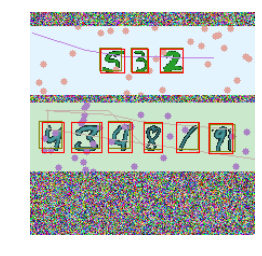

In [32]:
features_x,lables_y=get_next_minibatch(1)
result=z_detector(features_x)
test_captcha=np.transpose(features_x[0]*127.5+127.5,[1,2,0]).astype(np.float32)#把向量轉成opencv的HWC模式

test_captcha=test_captcha.copy()

print(test_captcha.shape)

#print(result[0][4,:,:])
#print(sigmoid_np(result[0][4,:,:]).max())

words=[]
confidences=[]
answers=[]
for j in range(13):
    for i in range(13):
        #預測的邊界框
        if result[0][4,j,i]>=0.7: #如果objectness>0.7
            print('預測框向量:{0}'.format(result[0][:5,j,i]))
            print('實際框向量:{0}'.format(lables_y[0][:5,j,i]))
            pred_class=np.argmax(result[0][5:,j,i]) #預測類別
            words.append(pred_class)
            confidences.append(result[0][4,j,i])
            pred_xc=i*16+(result[0][0,j,i])*16.0
            pred_yc=j*16+(result[0][1,j,i])*16.0
            pred_w=math.exp(result[0][2,j,i])*16.0
            pred_h=math.exp(result[0][3,j,i])*16.0
            color =(0,128,128)
            cv2.rectangle(test_captcha, (int(pred_xc-0.5-0.5*pred_w), int(pred_yc-0.5-0.5*pred_h)), (int(pred_xc+0.5+0.5*pred_w), int(pred_yc+0.5+0.5*pred_h)), color, 1)
        #實際的邊界框
        if lables_y[0][4,j,i]>0.7: #如果objectness>0.5
            actual_class=np.argmax(lables_y[0][5:,j,i]) #預測類別
            answers.append(actual_class)
            actual_xc=i*16+(lables_y[0][0,j,i]*16.0)
            actual_yc=j*16+(lables_y[0][1,j,i]*16.0)
            actual_w=math.exp(lables_y[0][2,j,i])*16.0
            actual_h=math.exp(lables_y[0][3,j,i])*16.0
            color =(0,0,255)
            cv2.rectangle(test_captcha, (int(actual_xc-0.5-0.5*actual_w), int(actual_yc-0.5-0.5*actual_h)), (int(actual_xc+0.5+0.5*actual_w), int(actual_yc+0.5+0.5*actual_h)), color, 1)
  
            
test_captcha=cv2.cvtColor(test_captcha,cv2.COLOR_BGR2RGB)
test_captcha=Image.fromarray(test_captcha.astype(np.uint8))



print('預測結果:{0}'.format(words))
print('信心水準:{0}'.format(confidences))
print('實際結果:{0}'.format(answers))

plt.axis('off')
plt.imshow(test_captcha)
